In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install optuna
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 14.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from math import sqrt
from scipy import stats as st
from random import randrange
from matplotlib import pyplot

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

import shap

# Preparing Data

In [4]:
#Open csv file.

data = pd.read_csv('/content/drive/MyDrive/NTDB-Epidural/final_data.csv', index_col = 0)

In [5]:
data['Discharge Disposition'].value_counts(normalize=False, dropna=False)

Discharged to home or self-care (routine discharge)                                                 3153
NaN                                                                                                  354
Discharged/Transferred to inpatient rehab or designated unit                                         326
Discharged/Transferred to home under care of organized home health service                           272
Discharged/Transferred to Skilled Nursing Facility (SNF)                                             233
Left against medical advice or discontinued care                                                     172
Deceased/Expired                                                                                      83
Discharged/Transferred to court/law enforcement.                                                      47
Discharged/Transferred to a short-term general hospital for inpatient care                            39
Discharged/Transferred to Long Term Care Hospital (LTCH

In [6]:
#Drop patients with unknown outcome of interest.

before = data.shape[0]
data = data[data['Discharge Disposition'].notna()]
after = data.shape[0]

excluded = before - after
print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  4790
Number of patients after exclusion:  4436
Number of patients excluded with this criteria:  354


In [7]:
#Define outcome of interest.

data.loc[data['Discharge Disposition'] == 'Deceased/Expired', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to hospice care', 'OUTCOME'] = 1
data.loc[data['OUTCOME'] != 1, 'OUTCOME'] = 0

data['OUTCOME'].value_counts(normalize=False, dropna=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.0    4332
1.0     104
Name: OUTCOME, dtype: int64

In [8]:
#Define predictor variables (x) and outcome of interest (y).

outcomes = ['Total Length of Stay', 'Discharge Disposition', 'Hospital Complication - Cardiac Arrest with CPR', 'Hospital Complication - Catheter-Associated Urinary Tract Infection (CAUTI)', 'Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)', 'Hospital Complication - Catheter-Related Blood Stream Infection', 'Hospital Complication - Deep Surgical Site Infection', 'Hospital Complication - Delirium', 'Hospital Complication - Alcohol Withdrawal Syndrome', 'Hospital Complication - Deep Vein Thrombosis (DVT)', 'Hospital Complication - Pulmonary Embolism', 'Hospital Complication - Extremity Compartment Syndrome', 'Hospital Complication - Graft or Prosthesis or Flap Failure', 'Hospital Complication - Unplanned Intubation', 'Hospital Complication - Acute Kidney Injury', 'Hospital Complication - Myocardial Infarction', 'Hospital Complication - Organ or Space Surgical Site Infection', 'Hospital Complication - Osteomyelitis', 'Hospital Complication - Pneumonia', 'Hospital Complication - Pressure or Decubitis Ulcer', 'Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)', 'Hospital Complication - Unplanned Return to the OR', 'Hospital Complication - Severe Sepsis', 'Hospital Complication - Stroke  or  CVA', 'Hospital Complication - Superficial Surgical Site Infection', 'Hospital Complication - Unplanned Admission to the ICU', 'Hospital Complication - Urinary Tract Infection', 'Hospital Complication - Ventilator-Associated Pneumonia (VAP)', 'Total ICU Length of Stay', 'OUTCOME']

x = data.drop(outcomes, axis = 1)
y = data['OUTCOME']

In [9]:
#Check data shapes.

print(y.shape)
print(x.shape)

(4436,)
(4436, 249)


In [10]:
#Split data into initial train set and test set in 80:20 ratio.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
  
#Describe initial train set and test set.

print("Number patients x_train dataset: ", x_train.shape[0])
print("Number patients y_train dataset: ", y_train.shape[0])
print("Number patients x_test dataset: ", x_test.shape[0])
print("Number patients y_test dataset: ", y_test.shape[0])

Number patients x_train dataset:  3548
Number patients y_train dataset:  3548
Number patients x_test dataset:  888
Number patients y_test dataset:  888


In [11]:
#Split initial train set into final train set and validation set in 75:25 ratio.

train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size = 0.25, random_state = 0)
  
#Describe train and validation sets.

print("Number patients train_x dataset: ", train_x.shape[0])
print("Number patients train_y dataset: ", train_y.shape[0])
print("Number patients valid_x dataset: ", valid_x.shape[0])
print("Number patients valid_y dataset: ", valid_y.shape[0])

Number patients train_x dataset:  2661
Number patients train_y dataset:  2661
Number patients valid_x dataset:  887
Number patients valid_y dataset:  887


In [12]:
#Describe outcome of interest before resampling.

print("Before resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("Before resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

Before resampling, counts of label '1': 69
Before resampling, counts of label '0': 2592 



In [13]:
#Apply SMOTE.

from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state = 0)
train_x, train_y = resampler.fit_resample(train_x, train_y)

In [14]:
#Describe outcome of interest after resampling.

print("After resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

After resampling, counts of label '1': 2592
After resampling, counts of label '0': 2592 



In [15]:
#Define function for 95% confidence intervals.

def roc_auc_ci(y_test, y_probs, positive=1):
    AUC = roc_auc_score(y_test, y_probs)
    N1 = sum(y_test == positive)
    N2 = sum(y_test != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# XGBoost

In [16]:
#Hyperparameter tuning for XGBoost.

def objective(trial):

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "seed": 31,
        "verbosity": 0,
        "objective":  trial.suggest_categorical("objective", ["binary:logistic"]),
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 1, 9),
        "eta" : trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100)
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    xgb_params = {}
    
    for key, value in trial.params.items():
        xgb_params[key] = value

[I 2023-01-23 03:23:33,410] A new study created in memory with name: no-name-8e8c2e60-e159-493c-955f-f4bf73cda56c


[0]	validation-auc:0.772718
[1]	validation-auc:0.712779
[2]	validation-auc:0.706153
[3]	validation-auc:0.811832
[4]	validation-auc:0.86359
[5]	validation-auc:0.856085
[6]	validation-auc:0.86927
[7]	validation-auc:0.88046
[8]	validation-auc:0.877857
[9]	validation-auc:0.888066


[I 2023-01-23 03:23:34,186] Trial 0 finished with value: 0.6355645706558486 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9428110874325094e-06, 'alpha': 0.4622155288125666, 'max_depth': 7, 'eta': 0.7851633597929335, 'gamma': 4.627257790053709e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6355645706558486.


[0]	validation-auc:0.588337
[1]	validation-auc:0.707201
[2]	validation-auc:0.705984
[3]	validation-auc:0.708655
[4]	validation-auc:0.706728
[5]	validation-auc:0.684888
[6]	validation-auc:0.706795
[7]	validation-auc:0.705477
[8]	validation-auc:0.70693
[9]	validation-auc:0.706795


[I 2023-01-23 03:23:34,995] Trial 1 finished with value: 0.5831643002028397 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.540855010579091e-08, 'alpha': 4.005546508605542e-08, 'max_depth': 5, 'eta': 5.190362998186933e-08, 'gamma': 1.1458984717217304e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6355645706558486.


[0]	validation-auc:0.5
[1]	validation-auc:0.587187
[2]	validation-auc:0.707066
[3]	validation-auc:0.706761
[4]	validation-auc:0.706795
[5]	validation-auc:0.708316
[6]	validation-auc:0.707066
[7]	validation-auc:0.706254
[8]	validation-auc:0.705815
[9]	validation-auc:0.684517


[I 2023-01-23 03:23:35,517] Trial 2 finished with value: 0.583739012846518 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.2472451918309905e-08, 'alpha': 3.5833391127860344e-07, 'max_depth': 5, 'eta': 3.166549087607022e-08, 'gamma': 2.4018078289549153e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6355645706558486.


[0]	validation-auc:0.598918
[1]	validation-auc:0.5976
[2]	validation-auc:0.595943
[3]	validation-auc:0.59432
[4]	validation-auc:0.592461
[5]	validation-auc:0.592292
[6]	validation-auc:0.590805
[7]	validation-auc:0.589959
[8]	validation-auc:0.589182
[9]	validation-auc:0.586815


[I 2023-01-23 03:23:37,243] Trial 3 finished with value: 0.5929344151453686 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3853144759016545e-06, 'alpha': 1.810306176116705e-05, 'max_depth': 8, 'eta': 0.00011313716853812925, 'gamma': 1.431538552328043e-06, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6355645706558486.


[0]	validation-auc:0.592934
[1]	validation-auc:0.591075
[2]	validation-auc:0.58952
[3]	validation-auc:0.589588
[4]	validation-auc:0.589283
[5]	validation-auc:0.589554
[6]	validation-auc:0.588709
[7]	validation-auc:0.588979
[8]	validation-auc:0.588742
[9]	validation-auc:0.588607


[I 2023-01-23 03:23:40,218] Trial 4 finished with value: 0.5877620013522651 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.981512489677599e-07, 'alpha': 8.673160455297617e-07, 'max_depth': 7, 'eta': 1.1789142339699406e-05, 'gamma': 4.915182221710387e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6355645706558486.


[0]	validation-auc:0.5
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.661156
[4]	validation-auc:0.661156


[I 2023-01-23 03:23:40,732] Trial 5 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.79405
[1]	validation-auc:0.791109
[2]	validation-auc:0.667208
[3]	validation-auc:0.670994
[4]	validation-auc:0.718087
[5]	validation-auc:0.718695
[6]	validation-auc:0.716193
[7]	validation-auc:0.716836
[8]	validation-auc:0.716633
[9]	validation-auc:0.719304


[I 2023-01-23 03:23:43,428] Trial 6 finished with value: 0.6506085192697769 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04528142691329445, 'alpha': 0.010014797160429703, 'max_depth': 5, 'eta': 0.08681503874329109, 'gamma': 1.7151544620195505e-06, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.6506085192697769.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.5
[4]	validation-auc:0.583739


[I 2023-01-23 03:23:44,240] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.685294
[1]	validation-auc:0.684381
[2]	validation-auc:0.58952
[3]	validation-auc:0.589588
[4]	validation-auc:0.589283


[I 2023-01-23 03:23:46,125] Trial 8 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.771805
[1]	validation-auc:0.770791
[2]	validation-auc:0.770825
[3]	validation-auc:0.769844
[4]	validation-auc:0.769236
[5]	validation-auc:0.769236
[6]	validation-auc:0.768627
[7]	validation-auc:0.768492
[8]	validation-auc:0.768425
[9]	validation-auc:0.768425


[I 2023-01-23 03:23:48,364] Trial 9 finished with value: 0.601656524678837 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.009931126321758296, 'alpha': 1.5117729868865979e-05, 'max_depth': 4, 'eta': 0.00026829123048597897, 'gamma': 5.2949738366436485e-05, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.6506085192697769.


[0]	validation-auc:0.767241
[1]	validation-auc:0.775017
[2]	validation-auc:0.829006
[3]	validation-auc:0.816498
[4]	validation-auc:0.790196
[5]	validation-auc:0.830933
[6]	validation-auc:0.823732
[7]	validation-auc:0.832826
[8]	validation-auc:0.812001
[9]	validation-auc:0.824307


[I 2023-01-23 03:23:49,487] Trial 10 finished with value: 0.7342461122379985 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.6016913090485729, 'alpha': 0.003516861545788762, 'max_depth': 2, 'eta': 0.33738276515229926, 'gamma': 0.027179735912078267, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.720352
[4]	validation-auc:0.720352
[5]	validation-auc:0.72096
[6]	validation-auc:0.72096
[7]	validation-auc:0.72789
[8]	validation-auc:0.727214
[9]	validation-auc:0.746112


[I 2023-01-23 03:23:51,057] Trial 11 finished with value: 0.6617308992562543 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.7463867502190047, 'alpha': 0.0042502402597866746, 'max_depth': 1, 'eta': 0.17498542259304714, 'gamma': 0.01775169471816696, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.661156
[4]	validation-auc:0.661156


[I 2023-01-23 03:23:51,591] Trial 12 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.767241
[1]	validation-auc:0.80213
[2]	validation-auc:0.813996
[3]	validation-auc:0.86119
[4]	validation-auc:0.848851
[5]	validation-auc:0.826268
[6]	validation-auc:0.835835
[7]	validation-auc:0.844388
[8]	validation-auc:0.838675
[9]	validation-auc:0.847634


[I 2023-01-23 03:23:53,117] Trial 13 finished with value: 0.7174780256930359 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.5134409125858265, 'alpha': 0.00770798064852616, 'max_depth': 2, 'eta': 0.8516409744831562, 'gamma': 0.5697473004700789, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.762137
[1]	validation-auc:0.762137
[2]	validation-auc:0.778059
[3]	validation-auc:0.778059
[4]	validation-auc:0.778059
[5]	validation-auc:0.778059
[6]	validation-auc:0.778059
[7]	validation-auc:0.778059
[8]	validation-auc:0.778059
[9]	validation-auc:0.778059


[I 2023-01-23 03:23:54,595] Trial 14 finished with value: 0.5982082488167682 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.02092466691621689, 'alpha': 0.06820023054475943, 'max_depth': 3, 'eta': 0.005882711473861857, 'gamma': 0.3290078599410596, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.762137
[1]	validation-auc:0.790027
[2]	validation-auc:0.775152
[3]	validation-auc:0.758114
[4]	validation-auc:0.764402
[5]	validation-auc:0.784618
[6]	validation-auc:0.806051
[7]	validation-auc:0.813049
[8]	validation-auc:0.827654
[9]	validation-auc:0.815551


[I 2023-01-23 03:23:56,031] Trial 15 finished with value: 0.6909398242055442 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0011900807431977616, 'alpha': 0.00035074985557253526, 'max_depth': 3, 'eta': 0.5755872416170457, 'gamma': 0.4476425004010761, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.767241
[3]	validation-auc:0.767241
[4]	validation-auc:0.767241
[5]	validation-auc:0.767241
[6]	validation-auc:0.767241
[7]	validation-auc:0.767241
[8]	validation-auc:0.767241
[9]	validation-auc:0.767241


[I 2023-01-23 03:23:57,349] Trial 16 finished with value: 0.7079107505070994 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.1477835060335413, 'alpha': 0.020592942288522754, 'max_depth': 2, 'eta': 0.008002468667740362, 'gamma': 0.0035938135921940555, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.767241
[1]	validation-auc:0.798817
[2]	validation-auc:0.858114
[3]	validation-auc:0.817951
[4]	validation-auc:0.822279
[5]	validation-auc:0.813928
[6]	validation-auc:0.800203
[7]	validation-auc:0.825017
[8]	validation-auc:0.830358
[9]	validation-auc:0.833705


[I 2023-01-23 03:23:58,589] Trial 17 finished with value: 0.6315415821501015 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.002898617160873941, 'alpha': 0.001497789427043957, 'max_depth': 2, 'eta': 0.9416272290601821, 'gamma': 0.8278043673947839, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.775592
[1]	validation-auc:0.775592
[2]	validation-auc:0.773834
[3]	validation-auc:0.774375
[4]	validation-auc:0.773225
[5]	validation-auc:0.772481
[6]	validation-auc:0.772346
[7]	validation-auc:0.772887
[8]	validation-auc:0.77238
[9]	validation-auc:0.77238


[I 2023-01-23 03:24:01,646] Trial 18 finished with value: 0.5710953346855985 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.18023645046691494, 'alpha': 0.12632542614910153, 'max_depth': 4, 'eta': 0.01169294972856409, 'gamma': 0.002826957265681652, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.767241
[3]	validation-auc:0.77664
[4]	validation-auc:0.786376
[5]	validation-auc:0.781271
[6]	validation-auc:0.778296
[7]	validation-auc:0.760548
[8]	validation-auc:0.7619
[9]	validation-auc:0.760345


[I 2023-01-23 03:24:02,635] Trial 19 finished with value: 0.7014874915483434 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.9560417578229341, 'alpha': 0.7879796512739659, 'max_depth': 2, 'eta': 0.059410986983613204, 'gamma': 0.07741535865448898, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.772786
[1]	validation-auc:0.669709
[2]	validation-auc:0.790027
[3]	validation-auc:0.783942
[4]	validation-auc:0.784719
[5]	validation-auc:0.702975
[6]	validation-auc:0.70071
[7]	validation-auc:0.701657
[8]	validation-auc:0.7024
[9]	validation-auc:0.705071


[I 2023-01-23 03:24:03,453] Trial 20 finished with value: 0.6061528059499663 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.08477307181054747, 'alpha': 0.028804403893846895, 'max_depth': 9, 'eta': 0.2191992270318456, 'gamma': 0.009436839922971839, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.767241
[3]	validation-auc:0.767241
[4]	validation-auc:0.767241


[I 2023-01-23 03:24:03,715] Trial 21 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.767241
[3]	validation-auc:0.767241
[4]	validation-auc:0.768492
[5]	validation-auc:0.786376
[6]	validation-auc:0.781271
[7]	validation-auc:0.778296
[8]	validation-auc:0.781271
[9]	validation-auc:0.7619


[I 2023-01-23 03:24:04,061] Trial 22 finished with value: 0.7014874915483434 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.29641049348533355, 'alpha': 0.015929874316269823, 'max_depth': 2, 'eta': 0.03947123577409796, 'gamma': 0.07944509203759922, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.776606
[1]	validation-auc:0.846586
[2]	validation-auc:0.885125
[3]	validation-auc:0.890196
[4]	validation-auc:0.895436
[5]	validation-auc:0.911494
[6]	validation-auc:0.908824
[7]	validation-auc:0.90666
[8]	validation-auc:0.893036
[9]	validation-auc:0.896247


[I 2023-01-23 03:24:04,528] Trial 23 finished with value: 0.6926639621365788 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.18698454703498088, 'alpha': 0.001096972915866366, 'max_depth': 4, 'eta': 0.9288260624563303, 'gamma': 0.0005165534207686763, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.762137
[1]	validation-auc:0.775693
[2]	validation-auc:0.787458
[3]	validation-auc:0.788134
[4]	validation-auc:0.800135
[5]	validation-auc:0.805139
[6]	validation-auc:0.79449
[7]	validation-auc:0.817512
[8]	validation-auc:0.8143
[9]	validation-auc:0.818256


[I 2023-01-23 03:24:04,964] Trial 24 finished with value: 0.6777214334009466 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.029855071304218345, 'alpha': 0.06221742699136913, 'max_depth': 3, 'eta': 0.17052323836051095, 'gamma': 0.21693961101299541, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.661156
[4]	validation-auc:0.661156


[I 2023-01-23 03:24:05,163] Trial 25 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.767241
[3]	validation-auc:0.767241
[4]	validation-auc:0.767241


[I 2023-01-23 03:24:05,401] Trial 26 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.694828
[1]	validation-auc:0.699899
[2]	validation-auc:0.668695
[3]	validation-auc:0.673698
[4]	validation-auc:0.666903


[I 2023-01-23 03:24:05,840] Trial 27 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.771805
[1]	validation-auc:0.777688
[2]	validation-auc:0.778499
[3]	validation-auc:0.774949
[4]	validation-auc:0.775558
[5]	validation-auc:0.777451
[6]	validation-auc:0.777181
[7]	validation-auc:0.777181
[8]	validation-auc:0.777248
[9]	validation-auc:0.778127


[I 2023-01-23 03:24:06,311] Trial 28 finished with value: 0.5710953346855985 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0011029267718262838, 'alpha': 0.027312896107615628, 'max_depth': 4, 'eta': 0.026257359081926696, 'gamma': 0.005372268357236237, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.758756
[1]	validation-auc:0.782454
[2]	validation-auc:0.78357
[3]	validation-auc:0.777721
[4]	validation-auc:0.840906
[5]	validation-auc:0.828634
[6]	validation-auc:0.838878
[7]	validation-auc:0.826876
[8]	validation-auc:0.825321
[9]	validation-auc:0.820284


[I 2023-01-23 03:24:06,728] Trial 29 finished with value: 0.6886409736308317 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.600994253031682e-05, 'alpha': 0.3798343812153204, 'max_depth': 3, 'eta': 0.32045390089582626, 'gamma': 0.001041036457254225, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.661156
[1]	validation-auc:0.660615
[2]	validation-auc:0.765247
[3]	validation-auc:0.830629
[4]	validation-auc:0.873428
[5]	validation-auc:0.89503
[6]	validation-auc:0.90027
[7]	validation-auc:0.899594
[8]	validation-auc:0.901623
[9]	validation-auc:0.865416


[I 2023-01-23 03:24:07,029] Trial 30 finished with value: 0.6996619337390129 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.017798904935828735, 'alpha': 0.14578047406632794, 'max_depth': 1, 'eta': 0.9481532716370756, 'gamma': 0.02163516440278012, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.77664
[3]	validation-auc:0.780865
[4]	validation-auc:0.761968
[5]	validation-auc:0.761562
[6]	validation-auc:0.760615
[7]	validation-auc:0.796619
[8]	validation-auc:0.797464
[9]	validation-auc:0.79902


[I 2023-01-23 03:24:07,377] Trial 31 finished with value: 0.6749492900608519 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.4999200939539225, 'alpha': 0.4090679908333775, 'max_depth': 2, 'eta': 0.10240663481090742, 'gamma': 0.048821897231492425, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.77664
[3]	validation-auc:0.77664
[4]	validation-auc:0.758181


[I 2023-01-23 03:24:07,622] Trial 32 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.767241
[3]	validation-auc:0.77664
[4]	validation-auc:0.786376
[5]	validation-auc:0.781271
[6]	validation-auc:0.778296
[7]	validation-auc:0.760548
[8]	validation-auc:0.7619
[9]	validation-auc:0.760345


[I 2023-01-23 03:24:08,003] Trial 33 finished with value: 0.7014874915483434 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.1452865107708407, 'alpha': 0.8510066100743071, 'max_depth': 2, 'eta': 0.055773710108141826, 'gamma': 0.048853605958216785, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.758756
[1]	validation-auc:0.782454
[2]	validation-auc:0.771264
[3]	validation-auc:0.787897
[4]	validation-auc:0.81288
[5]	validation-auc:0.815517
[6]	validation-auc:0.842022
[7]	validation-auc:0.834145
[8]	validation-auc:0.831305
[9]	validation-auc:0.855206


[I 2023-01-23 03:24:08,406] Trial 34 finished with value: 0.7094320486815416 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.38555659119405933, 'alpha': 0.04161820038809483, 'max_depth': 3, 'eta': 0.2625471213989467, 'gamma': 0.21188733153265674, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.762137
[1]	validation-auc:0.783266
[2]	validation-auc:0.77451
[3]	validation-auc:0.776369
[4]	validation-auc:0.777012
[5]	validation-auc:0.812576
[6]	validation-auc:0.813928
[7]	validation-auc:0.815247
[8]	validation-auc:0.809195
[9]	validation-auc:0.813827


[I 2023-01-23 03:24:08,850] Trial 35 finished with value: 0.6857674104124408 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.12438603208497918, 'alpha': 0.028415620600643596, 'max_depth': 3, 'eta': 0.31601351565863606, 'gamma': 0.26848684822811236, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.771704
[1]	validation-auc:0.771839
[2]	validation-auc:0.771636
[3]	validation-auc:0.772245
[4]	validation-auc:0.772448


[I 2023-01-23 03:24:09,249] Trial 36 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.720352
[3]	validation-auc:0.72096
[4]	validation-auc:0.78313
[5]	validation-auc:0.800372
[6]	validation-auc:0.809432
[7]	validation-auc:0.837221
[8]	validation-auc:0.856964
[9]	validation-auc:0.85453


[I 2023-01-23 03:24:09,533] Trial 37 finished with value: 0.6881676808654495 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.06095478369357852, 'alpha': 0.012685270614274267, 'max_depth': 1, 'eta': 0.39204536005282997, 'gamma': 0.5613470256617543, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.775592
[1]	validation-auc:0.803685
[2]	validation-auc:0.820149
[3]	validation-auc:0.846112
[4]	validation-auc:0.856018
[5]	validation-auc:0.843306
[6]	validation-auc:0.864571
[7]	validation-auc:0.855037
[8]	validation-auc:0.857471
[9]	validation-auc:0.869304


[I 2023-01-23 03:24:10,057] Trial 38 finished with value: 0.601555104800541 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.3425013312171932, 'alpha': 0.11297801756762628, 'max_depth': 4, 'eta': 0.4396901596285924, 'gamma': 0.13953904815767826, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.762137
[1]	validation-auc:0.777113
[2]	validation-auc:0.770791
[3]	validation-auc:0.783029
[4]	validation-auc:0.78215
[5]	validation-auc:0.787593
[6]	validation-auc:0.78641
[7]	validation-auc:0.79716
[8]	validation-auc:0.79858
[9]	validation-auc:0.801826


[I 2023-01-23 03:24:10,467] Trial 39 finished with value: 0.7025354969574037 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.056326333906893664, 'alpha': 0.05650226127116897, 'max_depth': 3, 'eta': 0.10667417532874358, 'gamma': 0.03278608529124217, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.797025
[1]	validation-auc:0.793374
[2]	validation-auc:0.715754
[3]	validation-auc:0.713726
[4]	validation-auc:0.713117
[5]	validation-auc:0.713996
[6]	validation-auc:0.714469
[7]	validation-auc:0.712847
[8]	validation-auc:0.670115
[9]	validation-auc:0.674915


[I 2023-01-23 03:24:11,034] Trial 40 finished with value: 0.5791413116970927 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.01537304164454717, 'alpha': 0.011918311806850651, 'max_depth': 5, 'eta': 0.024797336844251724, 'gamma': 0.005668492586085298, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.762137
[1]	validation-auc:0.775693
[2]	validation-auc:0.785091
[3]	validation-auc:0.781339
[4]	validation-auc:0.781542
[5]	validation-auc:0.791751
[6]	validation-auc:0.801488
[7]	validation-auc:0.800811
[8]	validation-auc:0.797634
[9]	validation-auc:0.794726


[I 2023-01-23 03:24:11,442] Trial 41 finished with value: 0.6696754563894523 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.07434346989263962, 'alpha': 0.052713390341424374, 'max_depth': 3, 'eta': 0.12232098594280423, 'gamma': 0.036569847632567806, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.762137
[1]	validation-auc:0.778059
[2]	validation-auc:0.775693
[3]	validation-auc:0.775693
[4]	validation-auc:0.783604
[5]	validation-auc:0.782759
[6]	validation-auc:0.784145


[I 2023-01-23 03:24:11,786] Trial 42 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.767241
[1]	validation-auc:0.775017
[2]	validation-auc:0.757945
[3]	validation-auc:0.791819
[4]	validation-auc:0.795504
[5]	validation-auc:0.835632
[6]	validation-auc:0.834381
[7]	validation-auc:0.835531
[8]	validation-auc:0.844422
[9]	validation-auc:0.847532


[I 2023-01-23 03:24:12,149] Trial 43 finished with value: 0.7336713995943205 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.4412148478671244, 'alpha': 0.20859107553393774, 'max_depth': 2, 'eta': 0.3741747209430166, 'gamma': 0.180360818333413, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.720352
[3]	validation-auc:0.72096
[4]	validation-auc:0.78313
[5]	validation-auc:0.800372
[6]	validation-auc:0.809432
[7]	validation-auc:0.831542
[8]	validation-auc:0.851285
[9]	validation-auc:0.842901


[I 2023-01-23 03:24:12,436] Trial 44 finished with value: 0.6881676808654495 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.4334591910562553, 'alpha': 0.26316657151722656, 'max_depth': 1, 'eta': 0.37628321637550466, 'gamma': 0.3444515522367079, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.767241
[1]	validation-auc:0.804936
[2]	validation-auc:0.803144
[3]	validation-auc:0.852502
[4]	validation-auc:0.867039
[5]	validation-auc:0.866464
[6]	validation-auc:0.844963
[7]	validation-auc:0.845436
[8]	validation-auc:0.844456
[9]	validation-auc:0.856761


[I 2023-01-23 03:24:12,797] Trial 45 finished with value: 0.6880662609871534 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.18932800583934506, 'alpha': 0.00986789932060025, 'max_depth': 2, 'eta': 0.672581050613062, 'gamma': 0.9679760032370195, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.720352
[3]	validation-auc:0.720352
[4]	validation-auc:0.72096


[I 2023-01-23 03:24:13,026] Trial 46 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.767241
[3]	validation-auc:0.767241
[4]	validation-auc:0.768492
[5]	validation-auc:0.786376


[I 2023-01-23 03:24:13,295] Trial 47 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.661156
[4]	validation-auc:0.661156


[I 2023-01-23 03:24:13,504] Trial 48 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.767241
[1]	validation-auc:0.779581
[2]	validation-auc:0.832725
[3]	validation-auc:0.848073
[4]	validation-auc:0.823158
[5]	validation-auc:0.842968
[6]	validation-auc:0.826302
[7]	validation-auc:0.827552
[8]	validation-auc:0.821873
[9]	validation-auc:0.822211


[I 2023-01-23 03:24:13,860] Trial 49 finished with value: 0.710581473968898 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.9499903210618033, 'alpha': 0.0028281957913389565, 'max_depth': 2, 'eta': 0.5465903909891244, 'gamma': 0.20512068183698492, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.758756
[1]	validation-auc:0.788911
[2]	validation-auc:0.841143
[3]	validation-auc:0.88854
[4]	validation-auc:0.855443
[5]	validation-auc:0.861393
[6]	validation-auc:0.88215
[7]	validation-auc:0.901927
[8]	validation-auc:0.912542
[9]	validation-auc:0.912508


[I 2023-01-23 03:24:14,291] Trial 50 finished with value: 0.6078769438810008 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.9554028531649235, 'alpha': 0.00010162241152577693, 'max_depth': 3, 'eta': 0.9479069939739382, 'gamma': 0.47586360500725094, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.77664
[3]	validation-auc:0.757776
[4]	validation-auc:0.762576
[5]	validation-auc:0.805003
[6]	validation-auc:0.801217
[7]	validation-auc:0.807742
[8]	validation-auc:0.798411
[9]	validation-auc:0.798208


[I 2023-01-23 03:24:14,651] Trial 51 finished with value: 0.6732251521298175 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.32890761846272143, 'alpha': 0.002565266373967886, 'max_depth': 2, 'eta': 0.14594884772453723, 'gamma': 0.19129650457704292, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.767241
[1]	validation-auc:0.775017
[2]	validation-auc:0.763151
[3]	validation-auc:0.793239
[4]	validation-auc:0.797532
[5]	validation-auc:0.836849
[6]	validation-auc:0.837559
[7]	validation-auc:0.839959
[8]	validation-auc:0.837187
[9]	validation-auc:0.832725


[I 2023-01-23 03:24:15,004] Trial 52 finished with value: 0.707133198106829 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.10796480085733408, 'alpha': 0.017895618784561303, 'max_depth': 2, 'eta': 0.45162355429517875, 'gamma': 0.06715442837652161, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.720352
[4]	validation-auc:0.72096


[I 2023-01-23 03:24:15,226] Trial 53 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.767241
[1]	validation-auc:0.779581
[2]	validation-auc:0.767951
[3]	validation-auc:0.805105
[4]	validation-auc:0.819168
[5]	validation-auc:0.818864
[6]	validation-auc:0.843036
[7]	validation-auc:0.824375
[8]	validation-auc:0.828871
[9]	validation-auc:0.830358


[I 2023-01-23 03:24:15,569] Trial 54 finished with value: 0.6817444219066937 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.5195427397340521, 'alpha': 0.0006952482393338031, 'max_depth': 2, 'eta': 0.5138250696008501, 'gamma': 0.4699389275572021, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.758756
[1]	validation-auc:0.774679
[2]	validation-auc:0.772312
[3]	validation-auc:0.772312
[4]	validation-auc:0.784821


[I 2023-01-23 03:24:15,859] Trial 55 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.770453
[1]	validation-auc:0.83499
[2]	validation-auc:0.806897
[3]	validation-auc:0.865923
[4]	validation-auc:0.862644
[5]	validation-auc:0.883097
[6]	validation-auc:0.8762
[7]	validation-auc:0.888506
[8]	validation-auc:0.884922
[9]	validation-auc:0.863793


[I 2023-01-23 03:24:16,353] Trial 56 finished with value: 0.6078769438810008 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.08302934026012788, 'alpha': 0.002398663998769954, 'max_depth': 4, 'eta': 0.9775499911402787, 'gamma': 0.013511150532050688, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.767241
[1]	validation-auc:0.775017
[2]	validation-auc:0.781271
[3]	validation-auc:0.757776
[4]	validation-auc:0.799121


[I 2023-01-23 03:24:16,600] Trial 57 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.661156
[4]	validation-auc:0.661156


[I 2023-01-23 03:24:16,817] Trial 58 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.758756
[1]	validation-auc:0.774679
[2]	validation-auc:0.774679
[3]	validation-auc:0.772312
[4]	validation-auc:0.772312


[I 2023-01-23 03:24:17,124] Trial 59 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.767241
[1]	validation-auc:0.775017
[2]	validation-auc:0.758722
[3]	validation-auc:0.813658
[4]	validation-auc:0.82096
[5]	validation-auc:0.805071
[6]	validation-auc:0.837289
[7]	validation-auc:0.828769
[8]	validation-auc:0.83641
[9]	validation-auc:0.817681


[I 2023-01-23 03:24:17,479] Trial 60 finished with value: 0.7239012846517917 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.026096453979867394, 'alpha': 0.05502499303640995, 'max_depth': 2, 'eta': 0.2676136453010212, 'gamma': 0.2565349080611155, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.7342461122379985.


[0]	validation-auc:0.767241
[1]	validation-auc:0.775017
[2]	validation-auc:0.843002
[3]	validation-auc:0.826775
[4]	validation-auc:0.825794
[5]	validation-auc:0.838607
[6]	validation-auc:0.835125
[7]	validation-auc:0.835734
[8]	validation-auc:0.837052
[9]	validation-auc:0.851318


[I 2023-01-23 03:24:17,829] Trial 61 finished with value: 0.7371196754563893 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.27015726932308437, 'alpha': 0.04066444168241478, 'max_depth': 2, 'eta': 0.4839382490908057, 'gamma': 0.2720846673723521, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.7371196754563893.


[0]	validation-auc:0.767241
[1]	validation-auc:0.779581
[2]	validation-auc:0.767951
[3]	validation-auc:0.805646
[4]	validation-auc:0.819642
[5]	validation-auc:0.819675
[6]	validation-auc:0.843441
[7]	validation-auc:0.824307
[8]	validation-auc:0.830122
[9]	validation-auc:0.840331


[I 2023-01-23 03:24:18,183] Trial 62 finished with value: 0.6817444219066937 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.5588146049592239, 'alpha': 0.04058884241892636, 'max_depth': 2, 'eta': 0.5234377879628693, 'gamma': 0.2851165262837428, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.7371196754563893.


[0]	validation-auc:0.77522
[1]	validation-auc:0.784043
[2]	validation-auc:0.793847
[3]	validation-auc:0.750947
[4]	validation-auc:0.785091


[I 2023-01-23 03:24:18,709] Trial 63 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.77664
[3]	validation-auc:0.780865
[4]	validation-auc:0.761968


[I 2023-01-23 03:24:18,959] Trial 64 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.758756
[1]	validation-auc:0.789892
[2]	validation-auc:0.792258
[3]	validation-auc:0.764233
[4]	validation-auc:0.800811
[5]	validation-auc:0.830054
[6]	validation-auc:0.826268
[7]	validation-auc:0.826809
[8]	validation-auc:0.838066
[9]	validation-auc:0.819405


[I 2023-01-23 03:24:19,407] Trial 65 finished with value: 0.6874915483434753 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.2982351216975191, 'alpha': 0.007352671358147292, 'max_depth': 3, 'eta': 0.5411689302338754, 'gamma': 0.09298936040169513, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.7371196754563893.


[0]	validation-auc:0.775896
[1]	validation-auc:0.788641
[2]	validation-auc:0.796315
[3]	validation-auc:0.800609
[4]	validation-auc:0.798783
[5]	validation-auc:0.844354
[6]	validation-auc:0.855713
[7]	validation-auc:0.865281
[8]	validation-auc:0.862711
[9]	validation-auc:0.875085


[I 2023-01-23 03:24:20,198] Trial 66 finished with value: 0.605578093306288 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.9412375316613065, 'alpha': 0.06908684341299855, 'max_depth': 8, 'eta': 0.2831999517133373, 'gamma': 0.05384722387409894, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.7371196754563893.


[0]	validation-auc:0.767241
[1]	validation-auc:0.767241
[2]	validation-auc:0.77664
[3]	validation-auc:0.77664
[4]	validation-auc:0.758181


[I 2023-01-23 03:24:20,457] Trial 67 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.795436
[4]	validation-auc:0.820453
[5]	validation-auc:0.847938
[6]	validation-auc:0.87194
[7]	validation-auc:0.873665
[8]	validation-auc:0.877248
[9]	validation-auc:0.883198


[I 2023-01-23 03:24:20,752] Trial 68 finished with value: 0.7510141987829615 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.5190874521516503, 'alpha': 0.21976033463609398, 'max_depth': 1, 'eta': 0.6770236414386657, 'gamma': 0.6548329752569516, 'grow_policy': 'lossguide'}. Best is trial 68 with value: 0.7510141987829615.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.822549
[4]	validation-auc:0.841075
[5]	validation-auc:0.857302
[6]	validation-auc:0.877079
[7]	validation-auc:0.876978
[8]	validation-auc:0.881237
[9]	validation-auc:0.887255


[I 2023-01-23 03:24:21,076] Trial 69 finished with value: 0.7510141987829615 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.149776814621136, 'alpha': 0.23025110275874816, 'max_depth': 1, 'eta': 0.7234869285584427, 'gamma': 0.8378142147692176, 'grow_policy': 'lossguide'}. Best is trial 68 with value: 0.7510141987829615.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.816058
[3]	validation-auc:0.822549
[4]	validation-auc:0.851454
[5]	validation-auc:0.86403
[6]	validation-auc:0.86856
[7]	validation-auc:0.877789
[8]	validation-auc:0.890534
[9]	validation-auc:0.858249


[I 2023-01-23 03:24:21,373] Trial 70 finished with value: 0.7221771467207573 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0597809630017869, 'alpha': 0.5185696453731925, 'max_depth': 1, 'eta': 0.8879036729413177, 'gamma': 0.8874995496825927, 'grow_policy': 'lossguide'}. Best is trial 68 with value: 0.7510141987829615.


[0]	validation-auc:0.661156
[1]	validation-auc:0.660615
[2]	validation-auc:0.765247
[3]	validation-auc:0.830629
[4]	validation-auc:0.873563
[5]	validation-auc:0.895098
[6]	validation-auc:0.901352
[7]	validation-auc:0.89973
[8]	validation-auc:0.902366
[9]	validation-auc:0.86616


[I 2023-01-23 03:24:21,681] Trial 71 finished with value: 0.700236646382691 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.12502563333406833, 'alpha': 0.5378448659468156, 'max_depth': 1, 'eta': 0.9988421256105159, 'gamma': 0.6959068329918288, 'grow_policy': 'lossguide'}. Best is trial 68 with value: 0.7510141987829615.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.795436
[4]	validation-auc:0.79716
[5]	validation-auc:0.820453
[6]	validation-auc:0.849121
[7]	validation-auc:0.867309
[8]	validation-auc:0.870622
[9]	validation-auc:0.877383


[I 2023-01-23 03:24:21,986] Trial 72 finished with value: 0.7504394861392834 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.07091320053077646, 'alpha': 0.23037293681407245, 'max_depth': 1, 'eta': 0.6109210387269186, 'gamma': 0.8893841483132156, 'grow_policy': 'lossguide'}. Best is trial 68 with value: 0.7510141987829615.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.720352
[4]	validation-auc:0.720352


[I 2023-01-23 03:24:22,217] Trial 73 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.720352
[3]	validation-auc:0.72096
[4]	validation-auc:0.727214


[I 2023-01-23 03:24:22,445] Trial 74 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.795436
[4]	validation-auc:0.78313
[5]	validation-auc:0.822989
[6]	validation-auc:0.843644
[7]	validation-auc:0.864706
[8]	validation-auc:0.868864
[9]	validation-auc:0.874848


[I 2023-01-23 03:24:22,748] Trial 75 finished with value: 0.725050709939148 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.007967791032717376, 'alpha': 0.494763629589198, 'max_depth': 1, 'eta': 0.5676380262856826, 'gamma': 0.9561399001661267, 'grow_policy': 'lossguide'}. Best is trial 68 with value: 0.7510141987829615.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.795436
[4]	validation-auc:0.78313


[I 2023-01-23 03:24:22,967] Trial 76 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.661156
[4]	validation-auc:0.661156


[I 2023-01-23 03:24:23,184] Trial 77 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.720352
[3]	validation-auc:0.72096
[4]	validation-auc:0.72096


[I 2023-01-23 03:24:23,409] Trial 78 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.720352
[4]	validation-auc:0.720352


[I 2023-01-23 03:24:23,625] Trial 79 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.772549
[1]	validation-auc:0.804057
[2]	validation-auc:0.794692
[3]	validation-auc:0.800676
[4]	validation-auc:0.815551
[5]	validation-auc:0.808114


[I 2023-01-23 03:24:24,083] Trial 80 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.822549
[4]	validation-auc:0.841075
[5]	validation-auc:0.857302
[6]	validation-auc:0.879581
[7]	validation-auc:0.878127
[8]	validation-auc:0.882184
[9]	validation-auc:0.888201


[I 2023-01-23 03:24:24,408] Trial 81 finished with value: 0.7515889114266397 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.05245932060976553, 'alpha': 0.5187562594777299, 'max_depth': 1, 'eta': 0.7327074577624898, 'gamma': 0.7001635652285456, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.822549
[4]	validation-auc:0.841075
[5]	validation-auc:0.857302
[6]	validation-auc:0.877079
[7]	validation-auc:0.87664
[8]	validation-auc:0.880088
[9]	validation-auc:0.88597


[I 2023-01-23 03:24:24,718] Trial 82 finished with value: 0.7510141987829615 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.011728036248283431, 'alpha': 0.2261013662034746, 'max_depth': 1, 'eta': 0.7033894732215711, 'gamma': 0.5855201426362616, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.72096
[4]	validation-auc:0.78313


[I 2023-01-23 03:24:24,937] Trial 83 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.795436
[4]	validation-auc:0.820453
[5]	validation-auc:0.847938
[6]	validation-auc:0.871805
[7]	validation-auc:0.873259
[8]	validation-auc:0.876099
[9]	validation-auc:0.881373


[I 2023-01-23 03:24:25,246] Trial 84 finished with value: 0.7504394861392834 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.2463153920224118, 'alpha': 0.15066128763180028, 'max_depth': 1, 'eta': 0.6617832650777534, 'gamma': 0.1498267151770895, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.822549
[4]	validation-auc:0.841075
[5]	validation-auc:0.857302
[6]	validation-auc:0.877079
[7]	validation-auc:0.876978
[8]	validation-auc:0.881102
[9]	validation-auc:0.886984


[I 2023-01-23 03:24:25,556] Trial 85 finished with value: 0.7510141987829615 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.24531646699361814, 'alpha': 0.19303473138061947, 'max_depth': 1, 'eta': 0.7190860917854058, 'gamma': 0.3385143015175556, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.795436
[4]	validation-auc:0.820453
[5]	validation-auc:0.847566
[6]	validation-auc:0.852231
[7]	validation-auc:0.857573
[8]	validation-auc:0.875896
[9]	validation-auc:0.882184


[I 2023-01-23 03:24:25,856] Trial 86 finished with value: 0.7504394861392834 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.26193667497606943, 'alpha': 0.10345481987965835, 'max_depth': 1, 'eta': 0.6864676516664613, 'gamma': 0.35480228779785866, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.822549
[4]	validation-auc:0.841075
[5]	validation-auc:0.857302
[6]	validation-auc:0.879581
[7]	validation-auc:0.878398
[8]	validation-auc:0.883198
[9]	validation-auc:0.889351


[I 2023-01-23 03:24:26,162] Trial 87 finished with value: 0.7515889114266397 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.21570454353519197, 'alpha': 0.12835096835699053, 'max_depth': 1, 'eta': 0.7534445849989992, 'gamma': 0.35825723944052623, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.822549
[4]	validation-auc:0.841075
[5]	validation-auc:0.857302
[6]	validation-auc:0.879581
[7]	validation-auc:0.878127
[8]	validation-auc:0.882184
[9]	validation-auc:0.888201


[I 2023-01-23 03:24:26,496] Trial 88 finished with value: 0.7515889114266397 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04260685924008247, 'alpha': 0.13128544736886685, 'max_depth': 1, 'eta': 0.7310499508585513, 'gamma': 0.14175704357561722, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.795436
[4]	validation-auc:0.820453
[5]	validation-auc:0.847938
[6]	validation-auc:0.87194
[7]	validation-auc:0.873665
[8]	validation-auc:0.877248
[9]	validation-auc:0.883198


[I 2023-01-23 03:24:26,783] Trial 89 finished with value: 0.7510141987829615 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.07384078279563716, 'alpha': 0.1859942789705209, 'max_depth': 1, 'eta': 0.672293748951722, 'gamma': 0.12236455597580662, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.661156
[4]	validation-auc:0.720352


[I 2023-01-23 03:24:27,006] Trial 90 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.822549
[4]	validation-auc:0.841075
[5]	validation-auc:0.857302
[6]	validation-auc:0.879581
[7]	validation-auc:0.878398
[8]	validation-auc:0.883198
[9]	validation-auc:0.889351


[I 2023-01-23 03:24:27,308] Trial 91 finished with value: 0.7515889114266397 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.11550532093717873, 'alpha': 0.15320872554413809, 'max_depth': 1, 'eta': 0.7490667868198324, 'gamma': 0.14500675029740007, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.660615
[2]	validation-auc:0.765247
[3]	validation-auc:0.830629
[4]	validation-auc:0.873428
[5]	validation-auc:0.895504
[6]	validation-auc:0.900135
[7]	validation-auc:0.89716
[8]	validation-auc:0.900609
[9]	validation-auc:0.866092


[I 2023-01-23 03:24:27,626] Trial 92 finished with value: 0.725050709939148 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.11641001591115396, 'alpha': 0.19813828965357266, 'max_depth': 1, 'eta': 0.9034364432616658, 'gamma': 0.607286744650677, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.720352
[3]	validation-auc:0.72096
[4]	validation-auc:0.72096


[I 2023-01-23 03:24:27,853] Trial 93 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.795436
[4]	validation-auc:0.820453
[5]	validation-auc:0.847566
[6]	validation-auc:0.852231
[7]	validation-auc:0.857573
[8]	validation-auc:0.875896
[9]	validation-auc:0.882252


[I 2023-01-23 03:24:28,157] Trial 94 finished with value: 0.7504394861392834 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.023051129525808484, 'alpha': 0.290171211720033, 'max_depth': 1, 'eta': 0.687177850070207, 'gamma': 0.5521962854873808, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.661156
[3]	validation-auc:0.720352
[4]	validation-auc:0.72096


[I 2023-01-23 03:24:28,377] Trial 95 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.720352
[3]	validation-auc:0.72096
[4]	validation-auc:0.78313


[I 2023-01-23 03:24:28,604] Trial 96 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.661156
[1]	validation-auc:0.720352
[2]	validation-auc:0.72096
[3]	validation-auc:0.822549
[4]	validation-auc:0.841075
[5]	validation-auc:0.845774
[6]	validation-auc:0.868323
[7]	validation-auc:0.877383
[8]	validation-auc:0.88952
[9]	validation-auc:0.884111


[I 2023-01-23 03:24:28,920] Trial 97 finished with value: 0.7262001352265044 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.09601701577470802, 'alpha': 0.4456156662069395, 'max_depth': 1, 'eta': 0.7774411054618398, 'gamma': 0.09140784563843801, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.660615
[2]	validation-auc:0.765247
[3]	validation-auc:0.830629
[4]	validation-auc:0.873563
[5]	validation-auc:0.895098
[6]	validation-auc:0.901352
[7]	validation-auc:0.899662
[8]	validation-auc:0.902366
[9]	validation-auc:0.86616


[I 2023-01-23 03:24:29,226] Trial 98 finished with value: 0.700236646382691 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.12457341258730001, 'alpha': 0.14953875480720324, 'max_depth': 1, 'eta': 0.995535480558263, 'gamma': 0.29219963990283304, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 0.7515889114266397.


[0]	validation-auc:0.661156
[1]	validation-auc:0.661156
[2]	validation-auc:0.720352
[3]	validation-auc:0.72096
[4]	validation-auc:0.78313


[I 2023-01-23 03:24:29,442] Trial 99 pruned. Trial was pruned at iteration 5.


Number of finished trials: 100
Best trial:
  Value: 0.7515889114266397
  Params: 
    objective: binary:logistic
    booster: gbtree
    lambda: 0.05245932060976553
    alpha: 0.5187562594777299
    max_depth: 1
    eta: 0.7327074577624898
    gamma: 0.7001635652285456
    grow_policy: lossguide


In [17]:
#See XGBoost hyperparameters.

xgb_params['eval_metric'] = 'auc'
xgb_params['verbosity'] = 0
xgb_params['seed'] = 31

print(xgb_params)

{'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.05245932060976553, 'alpha': 0.5187562594777299, 'max_depth': 1, 'eta': 0.7327074577624898, 'gamma': 0.7001635652285456, 'grow_policy': 'lossguide', 'eval_metric': 'auc', 'verbosity': 0, 'seed': 31}


In [18]:
#Fit XGBoost.

from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_params)

xgb.fit(train_x, train_y)

XGBClassifier(alpha=0.5187562594777299, eta=0.7327074577624898,
              eval_metric='auc', gamma=0.7001635652285456,
              grow_policy='lossguide', lambda=0.05245932060976553, max_depth=1,
              seed=31, verbosity=0)

In [19]:
#Make predictions on the test set based on the trained XGBoost model.

preds_xgb = xgb.predict(x_test)

probs_xgb = xgb.predict_proba(x_test)
probs_xgb = probs_xgb[:, 1]

In [20]:
#Evaluate XGBoost model.

xgb_precision = round(precision_score(preds_xgb,y_test), 3)
xgb_recall = round(recall_score(preds_xgb,y_test), 3)
xgb_f1 = round(f1_score(preds_xgb,y_test), 3)
xgb_acc = round(accuracy_score(preds_xgb,y_test), 3)
xgb_mcc = round(matthews_corrcoef(y_test, preds_xgb), 3)
xgb_auroc = round(roc_auc_score(y_test, probs_xgb), 3)
xgb_auroc_ci_low, xgb_auroc_ci_high = roc_auc_ci(y_test, probs_xgb)
xgb_auroc_ci_low = round(xgb_auroc_ci_low, 3)
xgb_auroc_ci_high = round(xgb_auroc_ci_high, 3)
xgb_auroc = str(xgb_auroc) + ' (' + str(xgb_auroc_ci_low) + ' - ' + str(xgb_auroc_ci_high) + ')'

print("Precision: %.3f" % (xgb_precision))
print("Recall: %.3f" % (xgb_recall))
print("F1 Score: %.3f" %(xgb_f1))
print('Accuracy: %.3f' % (xgb_acc))
print('MCC: %.3f' % (xgb_mcc))
print('AUROC (95% CI): ', (xgb_auroc))

Precision: 0.667
Recall: 0.203
F1 Score: 0.312
Accuracy: 0.940
MCC: 0.347
AUROC (95% CI):  0.916 (0.827 - 1)


In [21]:
#Evaluate XGBoost model (PRC and AUPRC).

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, probs_xgb)
xgb_auprc = round(auc(xgb_recall, xgb_precision), 3)

print('AUPRC: %.3f' % (xgb_auprc))

AUPRC: 0.224


In [22]:
#Recalculate precision and recall for calculation purposes.

xgb_precision = round(precision_score(preds_xgb,y_test), 3)
xgb_recall = round(recall_score(preds_xgb,y_test), 3)

xgb_results = [xgb_precision, xgb_recall, xgb_f1, xgb_acc, xgb_mcc, xgb_auroc, xgb_auprc]

In [23]:
#Recalculate precision recall curve for plotting purposes.

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, probs_xgb)

# LightGBM

In [24]:
#Hyperparameter tuning for LightGBM.

def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective":  trial.suggest_categorical("objective", ["binary"]),
        "metric": "binary_logloss",
        "verbosity": -1,
        "random_state": 31,
        "boosting_type":  trial.suggest_categorical("boosting_type", ["gbdt"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    lgb_params = {}
    
    for key, value in trial.params.items():
        lgb_params[key] = value

[I 2023-01-23 03:24:30,903] A new study created in memory with name: no-name-9df24c7e-65bc-4854-b692-d1990cf2370c
[I 2023-01-23 03:24:31,262] Trial 0 finished with value: 0.6107505070993915 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 3.7539146567567113e-06, 'lambda_l2': 4.197107555914312, 'num_leaves': 198, 'feature_fraction': 0.9921220018554777, 'bagging_fraction': 0.5248992771428327, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.6107505070993915.
[I 2023-01-23 03:24:31,829] Trial 1 finished with value: 0.5853617308992562 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 4.147120569265409e-08, 'lambda_l2': 4.7642495437718086e-08, 'num_leaves': 140, 'feature_fraction': 0.45363982991084084, 'bagging_fraction': 0.629435960515788, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 0 with value: 0.6107505070993915.
[I 2023-01-23 03:24:32,434] Trial 2 finished with value: 0.5859364435429345 an

Number of finished trials: 100
Best trial:
  Value: 0.6995605138607167
  Params: 
    objective: binary
    boosting_type: gbdt
    lambda_l1: 8.209593225567577
    lambda_l2: 3.735539287372013e-05
    num_leaves: 245
    feature_fraction: 0.4052508625499753
    bagging_fraction: 0.7842355283923007
    bagging_freq: 7
    min_child_samples: 56


In [25]:
#See LightGBM hyperparameters.

lgb_params['metric'] = 'binary_logloss'
lgb_params['verbosity'] = -1
lgb_params['random_state'] = 31

print(lgb_params)

{'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 8.209593225567577, 'lambda_l2': 3.735539287372013e-05, 'num_leaves': 245, 'feature_fraction': 0.4052508625499753, 'bagging_fraction': 0.7842355283923007, 'bagging_freq': 7, 'min_child_samples': 56, 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': 31}


In [26]:
#Fit LightGBM.

import lightgbm as lgb

lgb = lgb.LGBMClassifier(**lgb_params)

lgb.fit(train_x, train_y)

LGBMClassifier(bagging_fraction=0.7842355283923007, bagging_freq=7,
               feature_fraction=0.4052508625499753, lambda_l1=8.209593225567577,
               lambda_l2=3.735539287372013e-05, metric='binary_logloss',
               min_child_samples=56, num_leaves=245, objective='binary',
               random_state=31, verbosity=-1)

In [27]:
#Make predictions on the test set based on the trained model.

preds_lgb = lgb.predict(x_test)

probs_lgb = lgb.predict_proba(x_test)
probs_lgb = probs_lgb[:, 1]

In [28]:
#Evaluate LightGBM model.

lgb_precision = round(precision_score(preds_lgb,y_test), 3)
lgb_recall = round(recall_score(preds_lgb,y_test), 3)
lgb_f1 = round(f1_score(preds_lgb,y_test), 3)
lgb_acc = round(accuracy_score(preds_lgb,y_test), 3)
lgb_mcc = round(matthews_corrcoef(y_test, preds_lgb), 3)
lgb_auroc = round(roc_auc_score(y_test, probs_lgb), 3)
lgb_auroc_ci_low, lgb_auroc_ci_high = roc_auc_ci(y_test, probs_lgb)
lgb_auroc_ci_low = round(lgb_auroc_ci_low, 3)
lgb_auroc_ci_high = round(lgb_auroc_ci_high, 3)
lgb_auroc = str(lgb_auroc) + ' (' + str(lgb_auroc_ci_low) + ' - ' + str(lgb_auroc_ci_high) + ')'

print("Precision: %.3f" % (lgb_precision))
print("Recall: %.3f" % (lgb_recall))
print("F1 Score: %.3f" %(lgb_f1))
print('Accuracy: %.3f' % (lgb_acc))
print('MCC: %.3f' % (lgb_mcc))
print('AUROC (95% CI): ', (lgb_auroc))

Precision: 0.500
Recall: 0.429
F1 Score: 0.462
Accuracy: 0.976
MCC: 0.451
AUROC (95% CI):  0.924 (0.839 - 1)


In [29]:
#Evaluate LightGBM model (PRC and AUPRC).

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, probs_lgb)
lgb_auprc = round(auc(lgb_recall, lgb_precision), 3)

print('AUPRC: %.3f' % (lgb_auprc))

AUPRC: 0.350


In [30]:
#Recalculate precision and recall for calculation purposes.

lgb_precision = round(precision_score(preds_lgb,y_test), 3)
lgb_recall = round(recall_score(preds_lgb,y_test), 3)

lgb_results = [lgb_precision, lgb_recall, lgb_f1, lgb_acc, lgb_mcc, lgb_auroc, lgb_auprc]

In [31]:
#Recalculate precision recall curve for plotting purposes.

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, probs_lgb)

# CatBoost

In [32]:
#Hyperparameter tuning for CatBoost.

from optuna.integration import CatBoostPruningCallback

def objective(trial: optuna.Trial) -> float:

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "random_state": 31,
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "AUC",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    pruning_callback.check_pruned()

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc

if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    cb_params = {}
    
    for key, value in trial.params.items():
        cb_params[key] = value

[I 2023-01-23 03:25:18,455] A new study created in memory with name: no-name-d09173f6-6cb2-4c5d-bf5b-88e592c1b460
CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2023-01-23 03:32:37,034] Trial 0 finished with value: 0.6424611223799865 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.058926810135424286, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.435346894873128}. Best is trial 0 with value: 0.6424611223799865.
CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2023-01-23 03:32:37,770] Trial 1 finished with value: 0.7054090601757945 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.046618730161301844, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.43630899917515}. Best is trial 1 with value: 0.7054090601757945.
CatBoostPruningCallback is

Number of finished trials: 19
Best trial:
  Value: 0.7054090601757945
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.046618730161301844
    depth: 6
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 9.43630899917515


In [33]:
#See CatBoost hyperparameters.

cb_params['used_ram_limit'] = '3gb'
cb_params['eval_metric'] = 'AUC'
cb_params['random_state'] = 31

print(cb_params)

{'objective': 'CrossEntropy', 'colsample_bylevel': 0.046618730161301844, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.43630899917515, 'used_ram_limit': '3gb', 'eval_metric': 'AUC', 'random_state': 31}


In [34]:
#Fit CatBoost.

from catboost import CatBoostClassifier

cb = CatBoostClassifier(**cb_params)

cb.fit(train_x, train_y)

0:	total: 8.51ms	remaining: 8.5s
1:	total: 13.5ms	remaining: 6.74s
2:	total: 18.3ms	remaining: 6.07s
3:	total: 23.2ms	remaining: 5.79s
4:	total: 27.9ms	remaining: 5.55s
5:	total: 33.5ms	remaining: 5.54s
6:	total: 38.4ms	remaining: 5.45s
7:	total: 43.5ms	remaining: 5.4s
8:	total: 49.4ms	remaining: 5.43s
9:	total: 53.8ms	remaining: 5.32s
10:	total: 58.3ms	remaining: 5.25s
11:	total: 62ms	remaining: 5.1s
12:	total: 67.8ms	remaining: 5.14s
13:	total: 72.9ms	remaining: 5.14s
14:	total: 77.6ms	remaining: 5.09s
15:	total: 85.1ms	remaining: 5.23s
16:	total: 91.6ms	remaining: 5.29s
17:	total: 96.4ms	remaining: 5.26s
18:	total: 105ms	remaining: 5.44s
19:	total: 110ms	remaining: 5.4s
20:	total: 115ms	remaining: 5.35s
21:	total: 120ms	remaining: 5.33s
22:	total: 126ms	remaining: 5.35s
23:	total: 131ms	remaining: 5.34s
24:	total: 136ms	remaining: 5.3s
25:	total: 141ms	remaining: 5.26s
26:	total: 145ms	remaining: 5.21s
27:	total: 149ms	remaining: 5.18s
28:	total: 154ms	remaining: 5.16s
29:	total: 15

In [35]:
#Make predictions on the test set based on the trained model.

preds_cb = cb.predict(x_test)

probs_cb = cb.predict_proba(x_test)
probs_cb = probs_cb[:, 1]

In [36]:
#Evaluate CatBoost model.

cb_precision = round(precision_score(preds_cb,y_test), 3)
cb_recall = round(recall_score(preds_cb,y_test), 3)
cb_f1 = round(f1_score(preds_cb,y_test), 3)
cb_acc = round(accuracy_score(preds_cb,y_test), 3)
cb_mcc = round(matthews_corrcoef(y_test, preds_cb), 3)
cb_auroc = round(roc_auc_score(y_test, probs_cb), 3)
cb_auroc_ci_low, cb_auroc_ci_high = roc_auc_ci(y_test, probs_cb)
cb_auroc_ci_low = round(cb_auroc_ci_low, 3)
cb_auroc_ci_high = round(cb_auroc_ci_high, 3)
cb_auroc = str(cb_auroc) + ' (' + str(cb_auroc_ci_low) + ' - ' + str(cb_auroc_ci_high) + ')'

print("Precision: %.3f" % (cb_precision))
print("Recall: %.3f" % (cb_recall))
print("F1 Score: %.3f" %(cb_f1))
print('Accuracy: %.3f' % (cb_acc))
print('MCC: %.3f' % (cb_mcc))
print('AUROC (95% CI): ', (cb_auroc))

Precision: 0.222
Recall: 0.444
F1 Score: 0.296
Accuracy: 0.979
MCC: 0.305
AUROC (95% CI):  0.922 (0.835 - 1)


In [37]:
#Evaluate CatBoost model (PRC and AUPRC).

cb_precision, cb_recall, _ = precision_recall_curve(y_test, probs_cb)
cb_auprc = round(auc(cb_recall, cb_precision), 3)

print('AUPRC: %.3f' % (cb_auprc))

AUPRC: 0.380


In [38]:
#Recalculate precision and recall for calculation purposes.

cb_precision = round(precision_score(preds_cb,y_test), 3)
cb_recall = round(recall_score(preds_cb,y_test), 3)

cb_results = [cb_precision, cb_recall, cb_f1, cb_acc, cb_mcc, cb_auroc, cb_auprc]

In [39]:
#Recalculate precision recall curve for plotting purposes.

cb_precision, cb_recall, _ = precision_recall_curve(y_test, probs_cb)

# Random Forest

In [40]:
#Hyperparameter tuning for Random Forest.

def objective(trial):
    
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 31,
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt","log2", None]),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 1),
    }

    rf = RandomForestClassifier(**param)

    rf.fit(
        train_x,
        train_y,
    )

    preds = rf.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    rf_params = {}
    
    for key, value in trial.params.items():
        rf_params[key] = value

[I 2023-01-23 03:38:43,575] A new study created in memory with name: no-name-180cc1a2-b95e-43fd-b21b-b2688ea98292
[I 2023-01-23 03:38:45,287] Trial 0 finished with value: 0.5870858688302908 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 91, 'n_estimators': 200, 'min_samples_leaf': 1, 'min_samples_split': 6}. Best is trial 0 with value: 0.5870858688302908.
[I 2023-01-23 03:38:46,831] Trial 1 finished with value: 0.5853617308992562 and parameters: {'criterion': 'entropy', 'max_features': 'auto', 'max_depth': 45, 'n_estimators': 200, 'min_samples_leaf': 2, 'min_samples_split': 10}. Best is trial 0 with value: 0.5870858688302908.
[I 2023-01-23 03:39:03,291] Trial 2 finished with value: 0.5876605814739689 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 35, 'n_estimators': 2000, 'min_samples_leaf': 1, 'min_samples_split': 4}. Best is trial 2 with value: 0.5876605814739689.
[I 2023-01-23 03:39:04,983] Trial 3 finished with value: 0.557

Number of finished trials: 88
Best trial:
  Value: 0.7262001352265044
  Params: 
    criterion: gini
    max_features: log2
    max_depth: 2
    n_estimators: 700
    min_samples_leaf: 3
    min_samples_split: 3


In [41]:
#See Random Forest hyperparameters.

rf_params['random_state'] = 31

print(rf_params)

{'criterion': 'gini', 'max_features': 'log2', 'max_depth': 2, 'n_estimators': 700, 'min_samples_leaf': 3, 'min_samples_split': 3, 'random_state': 31}


In [42]:
#Fit Random Forest.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**rf_params)

rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=2, max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, n_estimators=700, random_state=31)

In [43]:
#Make predictions on the test set based on the trained model.

preds_rf = rf.predict(x_test)

probs_rf = rf.predict_proba(x_test)
probs_rf = probs_rf[:, 1]

In [44]:
#Evaluate Random Forest model.

rf_precision = round(precision_score(preds_rf,y_test), 3)
rf_recall = round(recall_score(preds_rf,y_test), 3)
rf_f1 = round(f1_score(preds_rf,y_test), 3)
rf_acc = round(accuracy_score(preds_rf,y_test), 3)
rf_mcc = round(matthews_corrcoef(y_test, preds_rf), 3)
rf_auroc = round(roc_auc_score(y_test, probs_rf), 3)
rf_auroc_ci_low, rf_auroc_ci_high = roc_auc_ci(y_test, probs_rf)
rf_auroc_ci_low = round(rf_auroc_ci_low, 3)
rf_auroc_ci_high = round(rf_auroc_ci_high, 3)
rf_auroc = str(rf_auroc) + ' (' + str(rf_auroc_ci_low) + ' - ' + str(rf_auroc_ci_high) + ')'

print("Precision: %.3f" % (rf_precision))
print("Recall: %.3f" % (rf_recall))
print("F1 Score: %.3f" %(rf_f1))
print('Accuracy: %.3f' % (rf_acc))
print('MCC: %.3f' % (rf_mcc))
print('AUROC (95% CI): ', (rf_auroc))

Precision: 0.667
Recall: 0.162
F1 Score: 0.261
Accuracy: 0.923
MCC: 0.304
AUROC (95% CI):  0.893 (0.795 - 0.991)


In [45]:
#Evaluate Random Forest model (PRC and AUPRC).

rf_precision, rf_recall, _ = precision_recall_curve(y_test, probs_rf)
rf_auprc = round(auc(rf_recall, rf_precision), 3)

print('AUPRC: %.3f' % (rf_auprc))

AUPRC: 0.284


In [46]:
#Recalculate precision and recall for calculation purposes.

rf_precision = round(precision_score(preds_rf,y_test), 3)
rf_recall = round(recall_score(preds_rf,y_test), 3)

rf_results = [rf_precision, rf_recall, rf_f1, rf_acc, rf_mcc, rf_auroc, rf_auprc]

In [47]:
#Recalculate precision recall curve for plotting purposes.

rf_precision, rf_recall, _ = precision_recall_curve(y_test, probs_rf)

# ROC and PR Curves

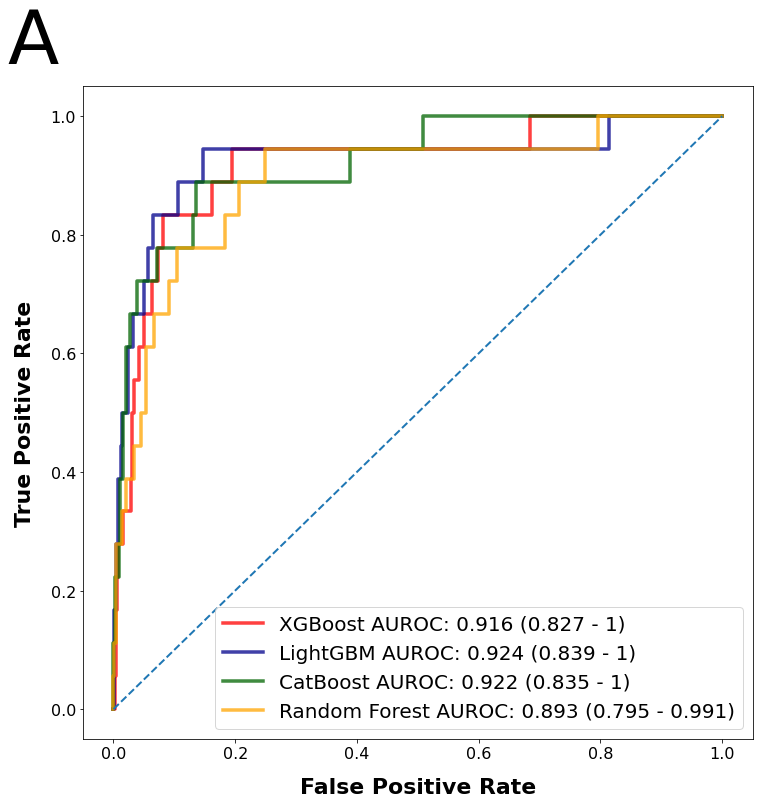

In [48]:
#Plot ROC curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, probs_xgb)
xgb_label = 'XGBoost AUROC: ' + xgb_auroc
pyplot.plot(xgb_fpr, xgb_tpr, label = xgb_label, color = 'red', linewidth = 3.5, alpha = 0.75)

lgb_fpr, lgb_tpr, _ = roc_curve(y_test, probs_lgb)
lgb_label = 'LightGBM AUROC: ' + lgb_auroc
pyplot.plot(lgb_fpr, lgb_tpr, label = lgb_label, color='darkblue', linewidth = 3.5, alpha = 0.75)

cb_fpr, cb_tpr, _ = roc_curve(y_test, probs_cb)
cb_label = 'CatBoost AUROC: ' + cb_auroc
pyplot.plot(cb_fpr, cb_tpr, label = cb_label, color = 'darkgreen', linewidth = 3.5, alpha = 0.75)

rf_fpr, rf_tpr, _ = roc_curve(y_test, probs_rf)
rf_label = 'Random Forest AUROC: ' + rf_auroc
pyplot.plot(rf_fpr, rf_tpr, label = rf_label, color = 'orange', linewidth = 3.5, alpha = 0.75)

pyplot.plot([0, 1], [0, 1], linestyle = '--', linewidth=2)

pyplot.title('A', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('False Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('True Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower right', fontsize = 20)

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/mortality_roc.png', dpi=300)
pyplot.show()

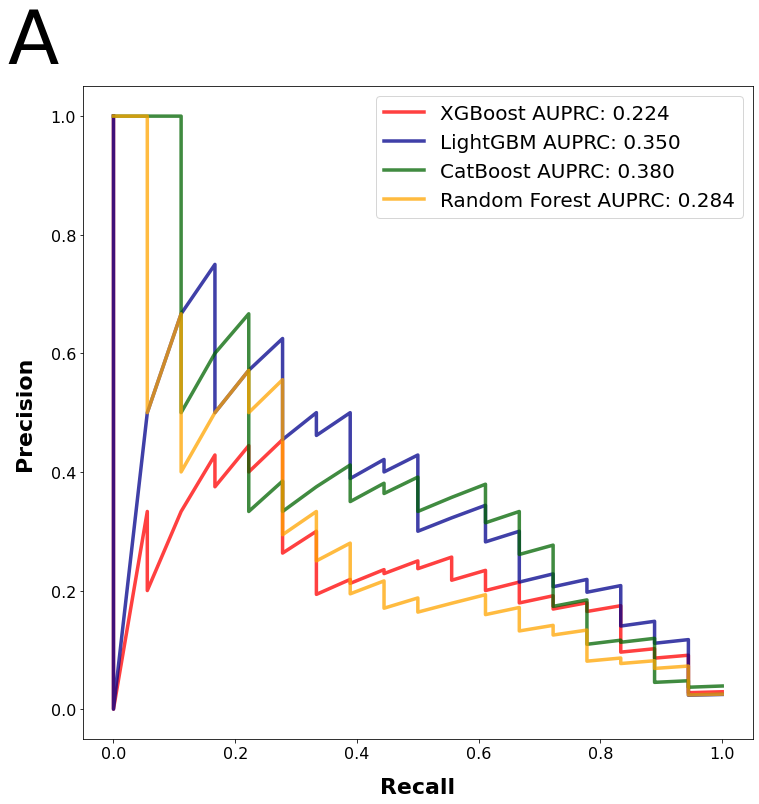

In [49]:
#Plot PR curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

pyplot.plot(xgb_recall, xgb_precision, label='XGBoost AUPRC: {:.3f}'.format(xgb_auprc), color = 'red', linewidth = 3.5, alpha = 0.75)
pyplot.plot(lgb_recall, lgb_precision, label='LightGBM AUPRC: {:.3f}'.format(lgb_auprc), color = 'darkblue', linewidth = 3.5, alpha = 0.75)
pyplot.plot(cb_recall, cb_precision, label='CatBoost AUPRC: {:.3f}'.format(cb_auprc), color = 'darkgreen', linewidth = 3.5, alpha = 0.75)
pyplot.plot(rf_recall, rf_precision, label='Random Forest AUPRC: {:.3f}'.format(rf_auprc), color = 'orange', linewidth = 3.5, alpha = 0.75)


pyplot.title('A', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('Recall', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('Precision', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'upper right', fontsize = 20)

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/mortality_prc.png', dpi=300)
pyplot.show()

# Results Summary

In [50]:
results = {'XGBoost':xgb_results, 'LightGBM':lgb_results, 'CatBoost':cb_results, 'Random Forest':rf_results}

results = pd.DataFrame(results, columns = ['XGBoost', 'LightGBM', 'CatBoost', 'Random Forest'])

results

,XGBoost,LightGBM,CatBoost,Random Forest
0,0.667,0.5,0.222,0.667
1,0.203,0.429,0.444,0.162
2,0.312,0.462,0.296,0.261
3,0.94,0.976,0.979,0.923
4,0.347,0.451,0.305,0.304
5,0.916 (0.827 - 1),0.924 (0.839 - 1),0.922 (0.835 - 1),0.893 (0.795 - 0.991)
6,0.224,0.35,0.38,0.284


In [51]:
results = pd.DataFrame({'XGBoost':xgb_results, 'LightGBM':lgb_results, 'CatBoost':cb_results, 'Random Forest':rf_results})

results = results.T

results.columns = ['Precision', 'Recall', 'F1', 'Accuracy', 'MCC', 'AUROC (95% CI)', 'AUPRC']

results.to_csv('/content/drive/MyDrive/NTDB-Epidural/mortality_results.csv')

results

,Precision,Recall,F1,Accuracy,MCC,AUROC (95% CI),AUPRC
XGBoost,0.667,0.203,0.312,0.94,0.347,0.916 (0.827 - 1),0.224
LightGBM,0.5,0.429,0.462,0.976,0.451,0.924 (0.839 - 1),0.35
CatBoost,0.222,0.444,0.296,0.979,0.305,0.922 (0.835 - 1),0.38
Random Forest,0.667,0.162,0.261,0.923,0.304,0.893 (0.795 - 0.991),0.284


# SHAP Plots

In [52]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [53]:
#Calculate SHAP values for XGBoost.

xgb_explainer = shap.Explainer(xgb.predict, x_test)
xgb_shap_values = xgb_explainer(x_test)

Permutation explainer: 889it [01:54,  7.29it/s]


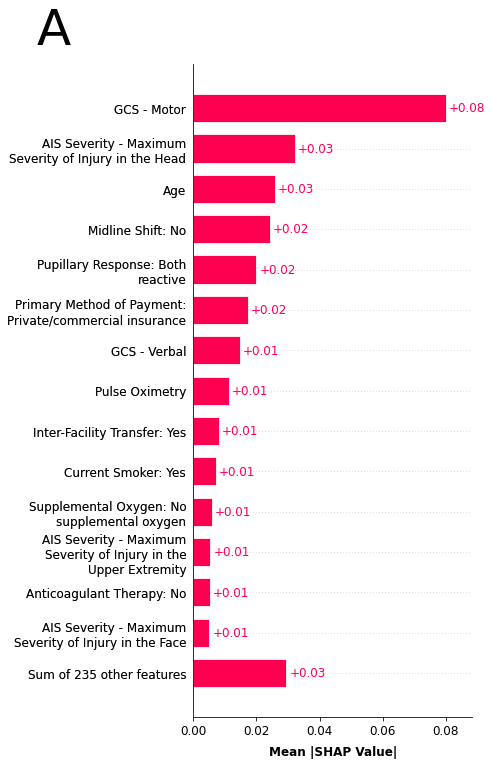

In [54]:
#Plot SHAP bar plot for XGBoost.

shap.plots.bar(xgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/mortality_shap_xgb.png', dpi=300, bbox_inches='tight')

In [55]:
#Calculate SHAP values for LightGBM.

lgb_explainer = shap.Explainer(lgb.predict, x_test)
lgb_shap_values = lgb_explainer(x_test)

Permutation explainer: 889it [03:06,  4.50it/s]


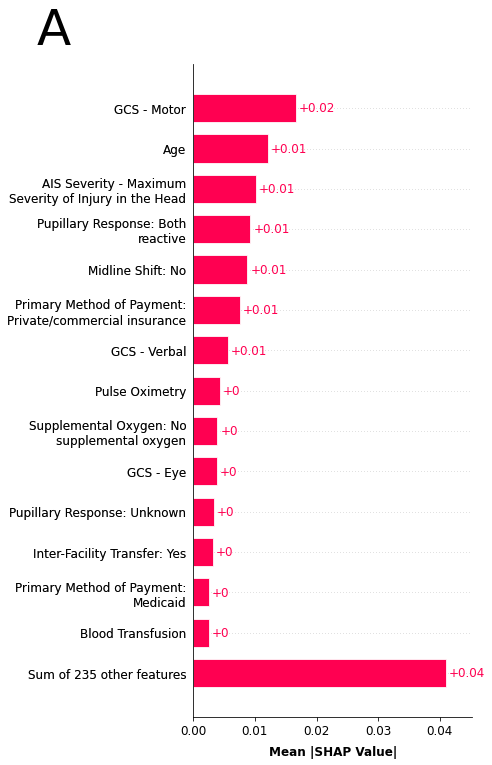

In [56]:
#Plot SHAP bar plot for LightGBM.

shap.plots.bar(lgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/mortality_shap_lgb.png', dpi=300, bbox_inches='tight')

In [57]:
#Calculate SHAP values for CatBoost.

cb_explainer = shap.Explainer(cb.predict, x_test)
cb_shap_values = cb_explainer(x_test)

Permutation explainer: 889it [02:52,  4.84it/s]


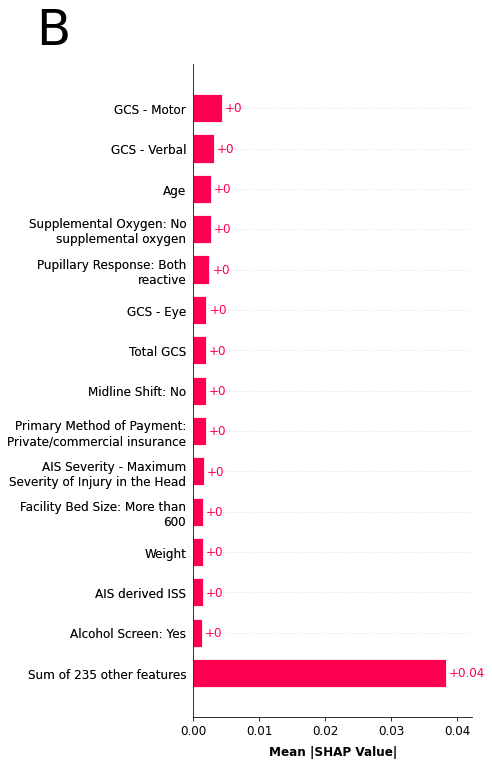

In [58]:
#Plot SHAP bar plot for CatBoost.

shap.plots.bar(cb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/mortality_shap_cb.png', dpi=300, bbox_inches='tight')

In [59]:
#Calculate SHAP values for Random Forest.

rf_explainer = shap.Explainer(rf.predict, x_test)
rf_shap_values = rf_explainer(x_test)

Permutation explainer: 889it [15:06,  1.03s/it]


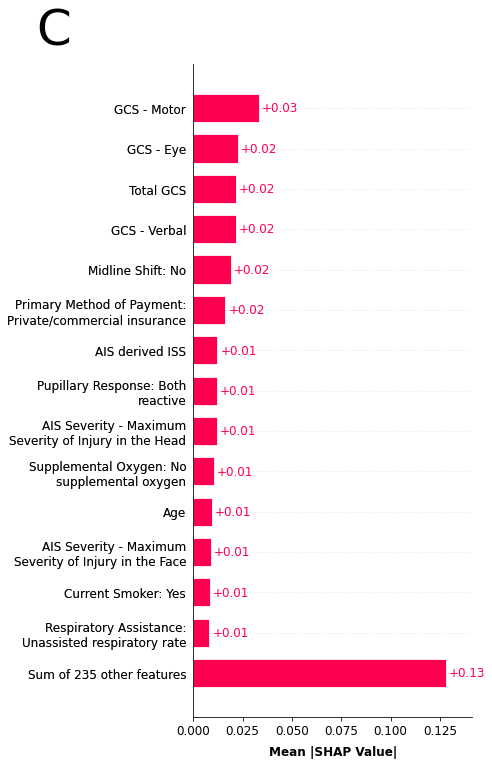

In [60]:
#Plot SHAP bar plot for Random Forest.

shap.plots.bar(rf_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/mortality_shap_rf.png', dpi=300, bbox_inches='tight')